In [1]:
from scipy.ndimage.measurements import label as bwlabel
from skimage.measure import regionprops
from pylab import *

import seaborn as sns

%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
sns.set()
rcParams['figure.figsize'] = (12, 8)

sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context("poster")

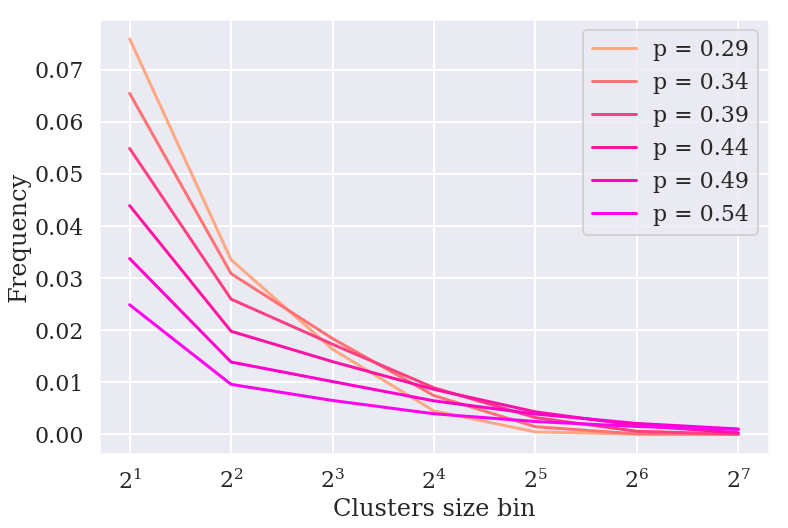

In [53]:
def percolation_matrix(p, L):
    """Creates and returns a labeled percolation matrix, and the number of clusters."""
    prob_matrix = rand(L, L)
    perc_matrix = prob_matrix < p
    
    label_perc_matrix, n_clusters = bwlabel(perc_matrix)
    return label_perc_matrix, n_clusters


def cluster_sizes(p, L):
    """
    Finds clusters sizes for a percolation matrix with p and L given and returns
    their areas, except for the spanning ones.
    """
    lw, num = percolation_matrix(p, L)
    
    cluster_infos = regionprops(lw)
    bboxs = array([cluster_infos[k]['bbox'] for k in range(len(cluster_infos))]).astype(int)
    
    if len(bboxs) > 0:
        jxs = argwhere(bboxs[:, 2] - bboxs[:, 0] < L)  # indecies where Xmax - Xmin < Lx
        jys = argwhere(bboxs[:, 3] - bboxs[:, 1] < L)  # indecies where Ymax - Ymin < Ly
        js = unique(vstack((jxs, jys)))  # Takes out only unique indecies
    
    areas = None
    if len(js) > 0:
        areas = array([cluster_infos[j]['area'] for j in js])
        
    return areas


def cluster_number_density(probs, cluster_bins, L, simulations_cycles):
    binned_clusters = zeros((len(probs), len(cluster_bins)-1))

    for i, prob in enumerate(probs):
        simulation_i = 0
        
        while simulation_i < simulations_cycles:
            areas = cluster_sizes(prob, L)
            binned_clusters[i, :] += histogram(areas, bins=cluster_bins)[0]
            simulation_i += 1
    
    binned_clusters /= (simulations_cycles*L**2.0)
    return binned_clusters

nbins = 8
cluster_bins = logspace(0, nbins-1, num=nbins, base=2)
L = 200
np = 6
probs = [0.29 + 0.05*i for i in range(np)]
simulations_cycles = 10

nspl = cluster_number_density(probs, cluster_bins, L, simulations_cycles)

with sns.cubehelix_palette(hue=5, n_colors=10, gamma=1):
    for i in range(np):
        plot(cluster_bins[1:], nspl[i, :], label="p = {}".format(probs[i]))
        
    legend()
    xlabel('Clusters size bin')
    ylabel('Frequency')
    gca().set_xscale("log", basex=2)

show()